In [70]:
import torch
import torch.optim as optim
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt

In [71]:
#Create PINN network

def create_pinn_network(input_dim=1, output_dim=2, hidden_dim=50, num_layers=3):
    """
    Args:
        input_dim: Dimension of input (1 for time)
        output_dim: Dimension of output (2 for S and I)
        hidden_dim: Number of neurons in hidden layers
        num_layers: Number of hidden layers
    
    Returns:
        A dictionary containing all network components
    """
    pinn_dict = {}
    
    # Known constants
    pinn_dict['N'] = 1000.0
    pinn_dict['S0'] = 999.0
    pinn_dict['I0'] = 1.0
    
    # Learnable SIR parameters
    pinn_dict['beta'] = torch.nn.Parameter(torch.tensor([0.3], dtype=torch.float32))
    pinn_dict['gamma'] = torch.nn.Parameter(torch.tensor([0.1], dtype=torch.float32))
    
    # All parameters for optimizer
    pinn_dict['parameters'] = [pinn_dict['beta'], pinn_dict['gamma']]
    
    # Input layer
    W1 = torch.nn.Parameter(torch.randn(hidden_dim, input_dim) * 0.1)
    b1 = torch.nn.Parameter(torch.zeros(hidden_dim))
    pinn_dict['W1'] = W1
    pinn_dict['b1'] = b1
    pinn_dict['parameters'].extend([W1, b1]) 
    #extend() is a method used for adding multiple items to a list at once
    
    # Hidden layers
    pinn_dict['hidden_weights'] = []
    pinn_dict['hidden_biases'] = []
    for i in range(num_layers - 1):
        W = torch.nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        b = torch.nn.Parameter(torch.zeros(hidden_dim))
        pinn_dict['hidden_weights'].append(W)
        pinn_dict['hidden_biases'].append(b)
        pinn_dict['parameters'].extend([W, b])
    
    # OUTPUT LAYER 
    W_out = torch.nn.Parameter(torch.randn(output_dim, hidden_dim) * 0.1)
    
    # Initialize biases at t=0:
    # S(0) ≈ 999 (sigmoid^-1(999/1000) ≈ 6.9)
    # I(0) ≈ 1 (sigmoid^-1(1/1000) ≈ -6.9)
    b_out_0 = 6.9  # For S
    b_out_1 = -6.9  # For I
    b_out = torch.nn.Parameter(torch.tensor([b_out_0, b_out_1], dtype=torch.float32))
    
    pinn_dict['W_out'] = W_out
    pinn_dict['b_out'] = b_out
    pinn_dict['parameters'].extend([W_out, b_out])
    return pinn_dict

In [72]:
#Forward pass

def forward_pass(pinn_dict, t):
    """
   Forward pass with output scaled between 0 and 1 using sigmoid,
    then multiplied by total population N.
    """
    if len(t.shape) == 1:
        t = t.view(-1, 1) 
#view() changes the tensor’s shape, without changing data, Converts a 1D tensor to a column vector
    
    # Input layer, matmul is matrix multiplication
    z = torch.matmul(t, pinn_dict['W1'].T) + pinn_dict['b1']
    a = torch.tanh(z)
    
    # Hidden layers
    for i in range(len(pinn_dict['hidden_weights'])):
        W = pinn_dict['hidden_weights'][i]
        b = pinn_dict['hidden_biases'][i]
        z = torch.matmul(a, W.T) + b
        a = torch.tanh(z)
    
    # Output layer - NO ACTIVATION HERE
    output = torch.matmul(a, pinn_dict['W_out'].T) + pinn_dict['b_out']
    
    # Apply sigmoid and scale by population N
    N = pinn_dict['N']
    S = N * torch.sigmoid(output[:, 0:1])  # Column 0 for S
    I = N * torch.sigmoid(output[:, 1:2])  # Column 1 for I
    
    return S, I

In [73]:
#Compute derivatives dS/dt and dI/dt using automatic differentiation.

def compute_derivatives_func(pinn_dict, t):
    """Compute dS/dt and dI/dt using autograd
    Args:
        pinn_dict: Dictionary containing network parameters
        t: Time tensor
    
    Returns:
        S, I: Network predictions
        dS_dt, dI_dt: Derivatives with respect to time
    """
    #if t is not set to compute gradients, If not:copy the tensor & enable gradient tracking
    if not t.requires_grad:
        t = t.clone().requires_grad_(True) 
    
    # Get predictions
    S, I = forward_pass(pinn_dict, t)
    
    # Compute gradients
     # Compute gradient of S with respect to t
    # grad() returns a tuple, we take the first element
    dS_dt = grad(
        outputs=S,  ## What to differentiate
        inputs=t,  ## Differentiate with respect to
        grad_outputs=torch.ones_like(S),  ## Scale factor
        create_graph=True,     # Allow higher-order derivatives
        retain_graph=True       # Keep computation graph
    )[0]

    # Compute gradient of I with respect to t
    dI_dt = grad(
        outputs=I,
        inputs=t,
        grad_outputs=torch.ones_like(I),
        create_graph=True,
        retain_graph=True
    )[0]
    
    return S, I, dS_dt, dI_dt

In [74]:
#compute data loss

def compute_data_loss(pinn_dict, t_obs, I_obs):
    """ - Measures how well the network matches observed I(t) data
    - Mean Squared Error (MSE) between predicted and observed I
    
    Args:
        pinn_dict: Dictionary containing network parameters
        t_obs: Observed time points
        I_obs: Observed infected counts
    
    Returns:
        data_loss: MSE loss value"""
    S_pred, I_pred = forward_pass(pinn_dict, t_obs)
    data_loss = torch.mean((I_pred - I_obs) ** 2)
    return data_loss

In [75]:
#compute ODE loss

def compute_ode_loss(pinn_dict, t_collocation):
    """Loss for satisfying SIR ODEs
    - Ensures network predictions satisfy SIR differential equations
    - Evaluated at collocation points (can be more points than observations)
    - Residual = how much predictions violate the ODEs
    
    Args:
        pinn_dict: Dictionary containing network parameters
        t_collocation: Time points for ODE evaluation
    
    Returns:
        ode_loss: Physics loss value
    """
    S, I, dS_dt, dI_dt = compute_derivatives_func(pinn_dict, t_collocation)
    
    # Get parameters
    beta = torch.nn.functional.softplus(pinn_dict['beta'])  # Ensure positive
    gamma = torch.nn.functional.softplus(pinn_dict['gamma'])  # Ensure positive
    N = pinn_dict['N']
    
    # SIR ODE residuals
    residual_S = dS_dt + (beta/N) * S * I
    residual_I = dI_dt - (beta/N) * S * I + gamma * I
    
    # Mean squared residuals
    ode_loss = (torch.mean(residual_S ** 2) + torch.mean(residual_I ** 2)) / 2.0
    return ode_loss

In [76]:
def compute_ic_loss(pinn_dict):
    """Loss for initial conditions
     - Ensures network starts at correct initial values
    - S(0) and I(0) are assumed to be known
    - Penalizes deviation from these known values  
    Args:
        pinn_dict: Dictionary containing network parameters
    
    Returns:
        ic_loss: Initial condition loss value
    """
    # Create tensor for time 0
    t0 = torch.tensor([[0.0]], dtype=torch.float32)

    # Get predictions at time 0
    S0_pred, I0_pred = forward_pass(pinn_dict, t0)

    # Known initial conditions
    S0_true = torch.tensor([[pinn_dict['S0']]], dtype=torch.float32)
    I0_true = torch.tensor([[pinn_dict['I0']]], dtype=torch.float32)

    
    # Loss: squared difference from true initial conditions
    ic_loss_S = torch.mean((S0_pred - S0_true) ** 2)
    ic_loss_I = torch.mean((I0_pred - I0_true) ** 2)
    
    return ic_loss_S + ic_loss_I

In [77]:
def compute_total_loss(pinn_dict, t_obs, I_obs, t_collocation):
    """Combine all loss components"""
    data_loss = compute_data_loss(pinn_dict, t_obs, I_obs)
    ode_loss = compute_ode_loss(pinn_dict, t_collocation)
    ic_loss = compute_ic_loss(pinn_dict)
    
    # Weighted total loss
    total_loss = data_loss + ode_loss + ic_loss
    
    losses_dict = {
        'total': total_loss.item(),
        'data': data_loss.item(),
        'ode': ode_loss.item(),
        'ic': ic_loss.item()
    }
    
    return total_loss, losses_dict

In [78]:
#Training

def train_pinn_functional(pinn_dict, t_obs, I_obs, epochs=5000, lr=0.001):
    """- At each epoch:
        1. Compute total loss
        2. Compute gradients (backpropagation)
        3. Update parameters (gradient descent)
    
    Args:
        pinn_dict: Dictionary containing network parameters
        t_obs: Observed time points (numpy)
        I_obs: Observed infected counts (numpy)
        epochs: Number of training iterations
        lr: Learning rate
    
    Returns:
        pinn_dict: Trained network dictionary"""
    # Prepare tensors
    t_tensor = torch.tensor(t_obs, dtype=torch.float32).view(-1, 1)
    I_tensor = torch.tensor(I_obs, dtype=torch.float32).view(-1, 1)
    
    # Collocation points for ODE loss
    t_min, t_max = float(t_obs.min()), float(t_obs.max())
    t_colloc = torch.linspace(t_min, t_max, 200).view(-1, 1)
    
    # Optimizer
    optimizer = optim.Adam(pinn_dict['parameters'], lr=lr)
    
    # History
    history = {
        'epoch': [], 'total_loss': [], 'data_loss': [], 'ode_loss': [], 'ic_loss': [],
        'beta': [], 'gamma': []
    }
    
    
    for epoch in range(epochs):
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass and loss
        total_loss, losses_dict = compute_total_loss(pinn_dict, t_tensor, I_tensor, t_colloc)
        
        # Backward pass
        total_loss.backward()
        
        #  Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(pinn_dict['parameters'], max_norm=1.0)
        
        # Update
        optimizer.step()
        
        # Store history
        if epoch % 100 == 0 or epoch == epochs - 1:
            history['epoch'].append(epoch)
            history['total_loss'].append(losses_dict['total'])
            history['data_loss'].append(losses_dict['data'])
            history['ode_loss'].append(losses_dict['ode'])
            history['ic_loss'].append(losses_dict['ic'])
            history['beta'].append(torch.nn.functional.softplus(pinn_dict['beta']).item())
            history['gamma'].append(torch.nn.functional.softplus(pinn_dict['gamma']).item())
        
        # Print progress
        if epoch % 1000 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:5d}: "
                  f"Loss={losses_dict['total']:.6f}, "
                  f"Data={losses_dict['data']:.6f}, "
                  f"ODE={losses_dict['ode']:.6f}, "
                  f"β={torch.nn.functional.softplus(pinn_dict['beta']).item():.4f}, "
                  f"γ={torch.nn.functional.softplus(pinn_dict['gamma']).item():.4f}")
    
    return pinn_dict, history

In [79]:
#Make predictions with trained PINN

def predict_with_pinn(pinn_dict, t_values):
    """- Use trained network to predict S(t) and I(t) for new time points
    - No gradient computation needed (torch.no_grad for efficiency)
    
    Args:
        pinn_dict: Trained network dictionary
        t_values: Time points for prediction (numpy array or tensor)
    
    Returns: S_pred and I_pred"""

    # Convert to tensor
    if isinstance(t_values, np.ndarray):
        t_tensor = torch.tensor(t_values, dtype=torch.float32)
    else:
        t_tensor = t_values

    # Ensure correct shape
    if len(t_tensor.shape) == 1:
        t_tensor = t_tensor.view(-1, 1)
        
    # Make predictions 
    with torch.no_grad():
        S_pred, I_pred = forward_pass(pinn_dict, t_tensor)
    
    return S_pred.numpy(), I_pred.numpy()

In [80]:
#Generate synthetic SIR data

def generate_synthetic_data(beta_true=0.3, gamma_true=0.1, days=100, noise_level=0.05):
    N = 1000
    S0, I0 = 999, 1
    
    t = np.linspace(0, days, days + 1)
    S, I = np.zeros_like(t), np.zeros_like(t)
    incidence = np.zeros_like(t)  # Create FULL array for incidence
    
    S[0], I[0] = S0, I0
    incidence[0] = 0  # No infections at t=0
    
    for i in range(1, len(t)):
        dt = t[i] - t[i-1]
        new_infections = beta_true * S[i-1] * I[i-1] / N * dt
        
        incidence[i] = new_infections  # Store in array
        recoveries = gamma_true * I[i-1] * dt
        
        S[i] = S[i-1] - new_infections
        I[i] = I[i-1] + new_infections - recoveries
    
    # Add noise to infected
    I_noisy = I + noise_level * np.std(I) * np.random.randn(len(I))
    
    return t, S, I, I_noisy, incidence  

In [81]:
data= generate_synthetic_data(beta_true=0.3, gamma_true=0.1, days=100, noise_level=0.1)
t, S, I, I_noisy, incidence = data[0], data[1], data[2], data[3], data[4]

In [82]:
# Create PINN network
pinn = create_pinn_network()

In [83]:
trained_pinn, history = train_pinn_functional(
    pinn,
    t_obs=t,         # time points from synthetic data
    I_obs=I_noisy, # noisy infected data
    epochs=5000,     # number of training iterations
    lr=0.001         # learning rate
)

Epoch     0: Loss=19049.832031, Data=19049.609375, ODE=0.221865, β=0.8538, γ=0.7449
Epoch  1000: Loss=1174.522705, Data=150.454956, ODE=1022.337036, β=0.7746, γ=0.5349
Epoch  2000: Loss=500.749115, Data=188.614883, ODE=310.526123, β=0.7528, γ=0.3410
Epoch  3000: Loss=271.492371, Data=118.794205, ODE=151.197174, β=0.7170, γ=0.2361
Epoch  4000: Loss=188.138550, Data=122.835693, ODE=63.955246, β=0.6643, γ=0.1729
Epoch  4999: Loss=148.594269, Data=120.738922, ODE=26.748169, β=0.5954, γ=0.1340


In [84]:
S_pred, I_pred = predict_with_pinn(trained_pinn, t)

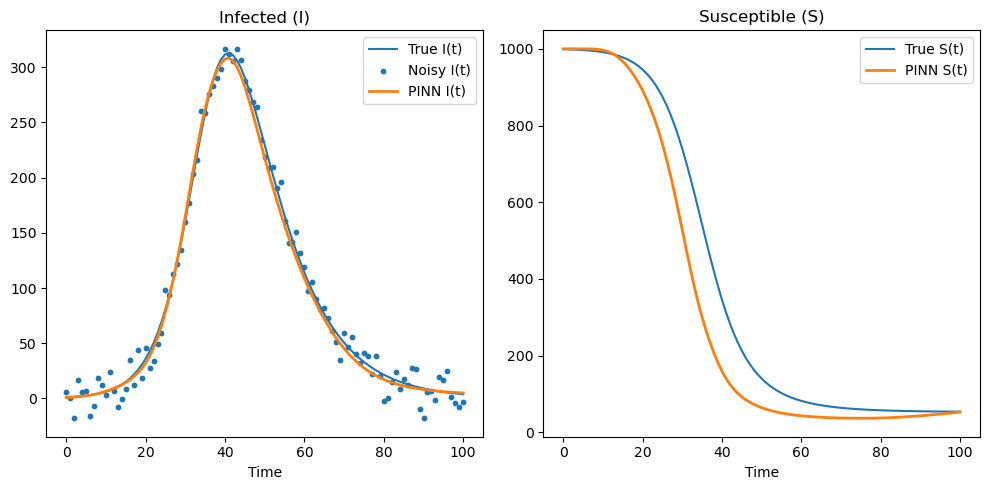

In [85]:
plt.figure(figsize=(10,5))

# Infected (Incidence)
plt.subplot(1,2,1)
plt.plot(t, I, label='True I(t)')
plt.scatter(t, I_noisy, label='Noisy I(t)', s=10)
plt.plot(t, I_pred, label='PINN I(t)', linewidth=2)
plt.title("Infected (I)")
plt.xlabel("Time")
plt.legend()

# Susceptible (S)
plt.subplot(1,2,2)
plt.plot(t, S, label='True S(t)')
plt.plot(t, S_pred, label='PINN S(t)', linewidth=2)
plt.title("Susceptible (S)")
plt.xlabel("Time")
plt.legend()

plt.tight_layout()
plt.show()

In [86]:
 # Get learned parameters
beta_learned = torch.nn.functional.softplus(trained_pinn['beta']).item()
gamma_learned = torch.nn.functional.softplus(trained_pinn['gamma']).item()
    
print(f"\nTrue parameters: β=0.3, γ=0.1")
print(f"Learned parameters: β={beta_learned:.4f}, γ={gamma_learned:.4f}")


True parameters: β=0.3, γ=0.1
Learned parameters: β=0.5954, γ=0.1340


In [87]:
#Calculation of incidence

N = trained_pinn['N']

# Calculate incidence DIRECTLY from SIR equation:
# Incidence = β * S * I / N
incidence_pred = (beta_learned / N) * S_pred * I_pred


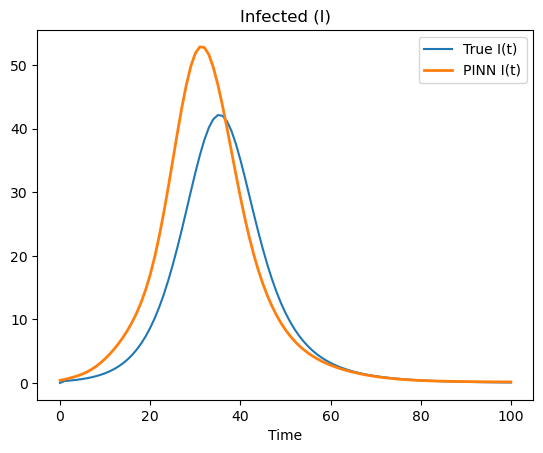

In [88]:
plt.plot(t, incidence, label='True I(t)')
plt.plot(t, incidence_pred, label='PINN I(t)', linewidth=2)
plt.title("Infected (I)")
plt.xlabel("Time")
plt.legend()